# Optimizing the KSD

In [1]:
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from functools import partial
from itertools import product

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets

import kernel_learning
import discrepancy_learner

from jax.experimental import optimizers

key = random.PRNGKey(0)
key, subkey = random.split(key)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
setup = distributions.banana_proposal
target, proposal = setup.get()

In [3]:
@partial(jit, static_argnums=1)
def compute_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

def get_sds(key, n_samples, fun):
    sds = []
    for subkey in random.split(key, 100):
        samples = proposal.sample(n_samples, key=subkey)
        sds.append(compute_sd(samples, fun))
    return sds

# Parameters

In [4]:
def l2_norm(fun, key):
    def fun_norm(x): return np.linalg.norm(fun(x))**2
    s = proposal.sample(10_000, key)
    return np.mean(vmap(fun_norm)(s))

def rescale_stein_gradient(key, fun: callable, m_opt):
    """fun: computes learned stein gradient (eg phi*)
    Returns rescaled fun s.t. E[fun^T fun] = m"""
    m_learned = l2_norm(fun, key)
    def fun_rescaled(x):
        return np.sqrt(m_learned / m_opt) * kl_grad(x)
    return fun_rescaled

def get_kl_gradient(lambda_reg):
    def kl_gradient(x):
        return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / (2*lambda_reg)
    return kl_gradient
    
def learn(sizes=[32, 32, 2], method="direct", sample_every=True, learning_rate = 0.01, n_steps=1000):
    """
    Learn the stein gradient.
    
    Arguments:
    method is one of 'direct', 'ksd_l2', 'ksd_std', 'ksd_none'
    
    Returns:
    instance of learner after training.
    """
    if method == 'ksd_l2':
        lambda_reg=1
        scaling_parameter=True
        std_normalize=False
    elif method == "ksd_std":
        lambda_reg=0
        scaling_parameter=False
        std_normalize=True
    elif method == "ksd_none":
        lambda_reg=0
        scaling_parameter=False
        std_normalize=False
    if "ksd" in method:
        learner = kernel_learning.KernelLearner(key,
                                                target,
                                                sizes,
                                                kernels.get_rbf_kernel(1),
                                                learning_rate,
                                                lambda_reg=lambda_reg,
                                                scaling_parameter=scaling_parameter,
                                                std_normalize=std_normalize)
    elif method == "direct":
        learner = discrepancy_learner.SDLearner(key,
                                                target,
                                                sizes,
                                                learning_rate,
                                                lambda_reg=1)
    else:
        raise ValueError(f"Got wrong value for method: {method}.")

    if sample_every:
        learner.train(samples=None, n_steps=n_steps, proposal=proposal, batch_size=400)
    else:
        samples = proposal.sample(400, subkey)
        learner.train(samples, n_steps=100)
    return learner

def compute_comparison(sizes=[32, 32, 2], method="direct", sample_every=True, learning_rate=1e-2, n_steps=[10**3]*4):
    assert len(n_steps) == 4
    methods = ["direct", "ksd_l2", "ksd_none", "ksd_std"]
    learner_direct, *ksd_learners = [learn(sizes=sizes,
                                           method=method,
                                           sample_every=sample_every,
                                           learning_rate=learning_rate,
                                           n_steps=n)
                                     for method, n in zip(methods, n_steps)]
    return learner_direct, ksd_learners

def get_rescaled_stein_discrepancies(key, learner_direct, ksd_learers):
    """
    compute SDs, KSDs, and rescale them so
    they can be compared.

    Arguments:
    learner_direct and ksd_learners are (list of) learner instances
    after training (so they carry all training log, parameter state, etc)
    """
    # get stein gradients:
    inducing_samples = proposal.sample(500)
    stein_grads = [learner_direct.get_f()]
    stein_grads.extend([learner.get_phistar(inducing_samples) for learner in ksd_learners])
    rbf_stein_gradient = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, inducing_samples)
    stein_grads.append(rbf_stein_gradient)
    stein_grads_names = ["Direct", "KSD L2", "KSD no regularization", "KSD Stddev", "KSD vanilla RBF"]

    # true gradient and optimal Stein discrepancy
    lambda_reg = learner_direct.lambda_reg
    key, subkey = random.split(key)
    true_kl_gradient = get_kl_gradient(lambda_reg)
    l2_norm_benchmark = np.sqrt(l2_norm(true_kl_gradient, subkey))
    key, subkey = random.split(key)
    optimal_sds = get_sds(subkey, 400, true_kl_gradient)

    # compute KSD and SD values
    print("Computing KSD and SD values...")
    key, subkey = random.split(key)
    sds_list = [get_sds(subkey, 400, stein_gradient)
           for subkey, stein_gradient in zip(random.split(subkey, len(stein_grads)), stein_grads)] # (6, 100)
    sds_array = np.array(sds_list)

    # compute L2(q) norms for non-L2 regularized stein gradients
    print("Rescaling KSD values...")
    unscaled_stein_gradients = stein_grads[2:]
    key, subkey = random.split(key)
    l2_norms_squared = [l2_norm(fun, skey) for skey, fun in zip(random.split(subkey, len(unscaled_stein_gradients)), unscaled_stein_gradients)]
    l2_norms = np.sqrt(np.array(l2_norms_squared).reshape(len(unscaled_stein_gradients), 1))
    sds_normed = sds_array[2:] / l2_norms
    sds_rescaled = sds_normed * l2_norm_benchmark

    sds_final = np.concatenate([sds_array[:2], sds_rescaled])
    return optimal_sds, sds_final, stein_grads_names

In [5]:
# n_steps=[10**3, 10**3, 10**2, 10**2]
n_steps = [10**3]*4
learner_direct, ksd_learners = compute_comparison(sizes=[32, 32, 2], n_steps=n_steps)

100%|██████████| 1000/1000 [07:49<00:00,  2.13it/s]


In [6]:
optimal_sds, sds_list, sds_names = get_rescaled_stein_discrepancies(key, learner_direct, ksd_learners)

Computing KSD and SD values...
Rescaling KSD values...


(0.0, 11.0)

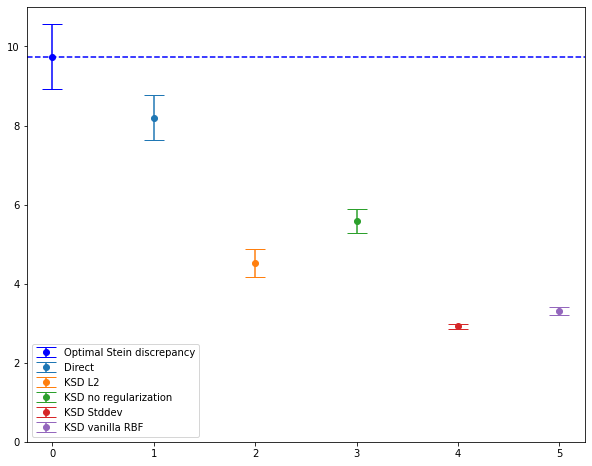

In [11]:
fig, ax = plt.subplots(figsize=[10, 8])
col="blue"
plt.axhline(y=onp.mean(optimal_sds), linestyle="--", color=col)
plt.errorbar(x=0, y=onp.mean(optimal_sds), yerr=onp.std(optimal_sds), fmt="o", capsize=10, label="Optimal Stein discrepancy", color=col)
for x, sds, label in zip(range(1, 6), sds_list, sds_names):
    plt.errorbar(x=x, y=onp.mean(sds), yerr=onp.std(sds), fmt="o", capsize=10, label=label)

plt.legend()
plt.ylim((0, 11))